#**Librerías**

In [5]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
import shutil

# Directorios originales
data_dir = "/content/drive/MyDrive/Visión por computador/semana12/"
san_dir = os.path.join(data_dir, '/content/drive/MyDrive/Visión por computador/semana12/good_quality/')
enf_dir = os.path.join(data_dir, '/content/drive/MyDrive/Visión por computador/semana12/bad_quality/')

# Obtener listas de imágenes
san_imagenes = [os.path.join(san_dir, img) for img in os.listdir(san_dir)]
enf_imagenes = [os.path.join(enf_dir, img) for img in os.listdir(enf_dir)]

# Crear etiquetas (0 para sanas, 1 para enfermas)
san_etiquetas = [0] * len(san_imagenes)
enf_etiquetas = [1] * len(enf_imagenes)

# Unir las listas
imagenes = np.array(san_imagenes + enf_imagenes)
etiquetas = np.array(san_etiquetas + enf_etiquetas)

# Dividir los datos en entrenamiento, validación y prueba (70% - 15% - 15%)
X_train, X_temp, y_train, y_temp = train_test_split(imagenes, etiquetas, test_size=0.3, stratify=etiquetas)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

# Crear carpetas de salida para las imágenes divididas
output_dir = "/content/drive/MyDrive/Visión por computador/images/"
os.makedirs(output_dir, exist_ok=True)
for folder in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, folder, 'naranjas_sanas'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, folder, 'naranjas_enfermas'), exist_ok=True)

# Función para copiar las imágenes a las carpetas respectivas
def copiar_imagenes(image_list, labels, set_name):
    for img_path, label in zip(image_list, labels):
        if label == 0:
            shutil.copy(img_path, os.path.join(output_dir, set_name, 'naranjas_sanas'))
        else:
            shutil.copy(img_path, os.path.join(output_dir, set_name, 'naranjas_enfermas'))

# Copiar las imágenes a los respectivos conjuntos
copiar_imagenes(X_train, y_train, 'train')
copiar_imagenes(X_val, y_val, 'val')
copiar_imagenes(X_test, y_test, 'test')


#**División de datos**

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creación de los generadores de imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Generadores para entrenamiento, validación y prueba
train_gen = datagen.flow_from_directory('/content/drive/MyDrive/Visión por computador/images/train/', target_size=(128, 128), batch_size=32, class_mode='binary')
val_gen = datagen.flow_from_directory('/content/drive/MyDrive/Visión por computador/images/val/', target_size=(128, 128), batch_size=32, class_mode='binary')
test_gen = datagen.flow_from_directory('/content/drive/MyDrive/Visión por computador/images/test/', target_size=(128, 128), batch_size=32, class_mode='binary')


Found 1481 images belonging to 2 classes.
Found 317 images belonging to 2 classes.
Found 318 images belonging to 2 classes.


#**Optimización de Hiperparámetros con Scikit-optimize**

In [8]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.9 MB/s eta 0:00:00


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [10]:
def crear_modelo(learning_rate, num_filters):
    model = Sequential()

    # Primera capa convolucional
    model.add(Conv2D(num_filters, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Segunda capa convolucional
    model.add(Conv2D(num_filters * 2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Capa aplanada
    model.add(Flatten())

    # Capa densa completamente conectada
    model.add(Dense(64, activation='relu'))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [11]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Espacio de búsqueda de hiperparámetros
dim_learning_rate = Real(low=1e-6, high=1e-1, prior='log-uniform', name='learning_rate')
dim_num_filters = Integer(low=16, high=128, name='num_filters')

dimensions = [dim_learning_rate, dim_num_filters]

# Definir la función a optimizar
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_filters):
    modelo = crear_modelo(learning_rate=learning_rate, num_filters=num_filters)

    history = modelo.fit(train_gen, validation_data=val_gen, epochs=10, verbose=0)
    accuracy = history.history['val_accuracy'][-1]  # Tomar la precisión de validación final

    return -accuracy  # Minimizar la pérdida (por eso el signo negativo)

# Ejecutar la optimización bayesiana
resultado = gp_minimize(func=fitness, dimensions=dimensions, n_calls=20, random_state=42)

print("Mejores hiperparámetros encontrados:")
print("Tasa de aprendizaje: ", resultado.x[0])
print("Número de filtros: ", resultado.x[1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().

Mejores hiperparámetros encontrados:
Tasa de aprendizaje:  0.0001682541077634012
Número de filtros:  115


In [12]:
# Obtener los mejores hiperparámetros
best_learning_rate = resultado.x[0]
best_num_filters = resultado.x[1]

# Crear y entrenar el modelo final con los mejores hiperparámetros
modelo_final = crear_modelo(learning_rate=best_learning_rate, num_filters=best_num_filters)

# Entrenar el modelo con los datos de entrenamiento y validación completos
history = modelo_final.fit(train_gen, validation_data=val_gen, epochs=50)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = modelo_final.evaluate(test_gen)
print(f"Pérdida en prueba: {test_loss}, Precisión en prueba: {test_acc}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 312ms/step - accuracy: 0.6266 - loss: 0.6326 - val_accuracy: 0.8927 - val_loss: 0.2639
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.9248 - loss: 0.2203 - val_accuracy: 0.9085 - val_loss: 0.1794
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.9617 - loss: 0.1040 - val_accuracy: 0.9243 - val_loss: 0.1460
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9471 - loss: 0.1388 - val_accuracy: 0.9590 - val_loss: 0.1273
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.9737 - loss: 0.0752 - val_accuracy: 0.9653 - val_loss: 0.0765
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.9767 - loss: 0.0640 - val_accuracy: 0.9653 - val_loss: 0.0723
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.9793 - loss: 0.0643 - val_accuracy: 0.9590 - val_loss: 0.0863
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.9871 - loss: 0.0432 - val_accura

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - accuracy: 0.9836 - loss: 0.0717
Pérdida en prueba: 0.041260913014411926, Precisión en prueba: 0.9842767119407654


#**Evaluación con métricas de desempeño**

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

predicciones = modelo_final.predict(test_gen)  # Usar modelo_final
predicciones_binarias = (predicciones > 0.5).astype(int)

# Cálculo de métricas
accuracy = accuracy_score(y_test, predicciones_binarias)
precision = precision_score(y_test, predicciones_binarias)
recall = recall_score(y_test, predicciones_binarias)
matriz_confusion = confusion_matrix(y_test, predicciones_binarias)

print(f"Exactitud: {accuracy}")
print(f"Precisión: {precision}")
print(f"Sensibilidad: {recall}")
print(f"Matriz de Confusión:\n{matriz_confusion}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step
Exactitud: 0.5188679245283019
Precisión: 0.47953216374269003
Sensibilidad: 0.5616438356164384
Matriz de Confusión:
[[83 89]
 [64 82]]


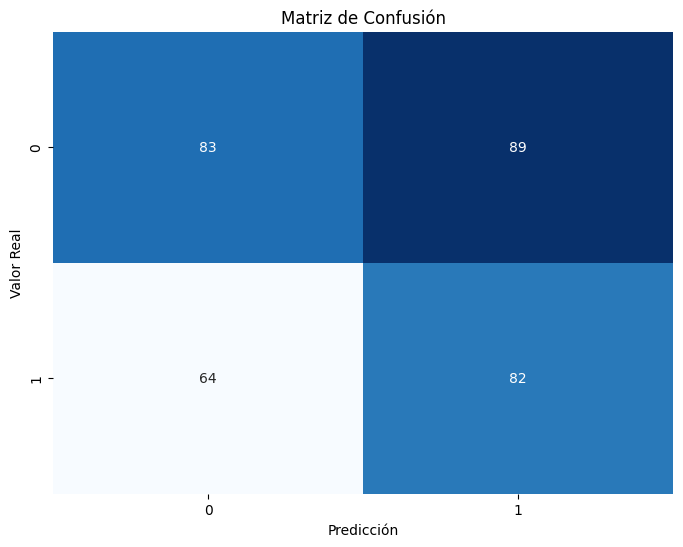

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()